![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 12 - Non-parametric Regression </center>
### <center> Local Polynomial Regression - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/12_NonparametricRegression/MainLocalPolynomialRegression_Solution.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Load the Boston house-prices dataset:

In [2]:
from sklearn.datasets import load_boston

mX, vY = load_boston(return_X_y=True)
mX.shape, vY.shape

((506, 13), (506,))

#### Normalize the data:

In [3]:
mX -= mX.mean(axis=0)
mX /= mX.std(axis=0)

vY -= vY.mean()
vY /= vY.std()

#### Leave one out cross-validation with <u>Pipeline</u>:

In [4]:
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.metrics         import r2_score
from sklearn.linear_model   import LinearRegression

oPolyfit = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
vHatY    = cross_val_predict(oPolyfit, mX, vY, cv=KFold(len(vY), shuffle=True))
scoreLR  = r2_score(vY, vHatY)
scoreLR

0.8465223539626408

### Local polynomial regression (with a Gaussian kernel):
$$\boldsymbol{p}^{\star}=\arg\min_{\boldsymbol{p}\in\mathbb{R}^{P+1}}\sum_{i=1}^{N}w_{i}\left(y_{i}-\boldsymbol{\phi}^{T}\left(x_{i}-x_{0}\right)\boldsymbol{p}\right)^{2}$$
where:
$$w_{i}=k\left(\left\Vert \frac{1}{h}\left(\boldsymbol{x}_{0}-\boldsymbol{x}_{i}\right)\right\Vert _{2}\right)$$
$$k\left(u\right)=e^{-\frac{1}{2}u^{2}}$$

In [5]:
from scipy.spatial.distance import cdist
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.preprocessing  import FunctionTransformer
from sklearn.linear_model   import LinearRegression

#-- Gaussian kernel:
def Kernel(vU):
    return np.exp(-vU**2 / (2 * h)**2)

#-- Estimate f(x_0):
def LocalPolynomialRegression(vX0, mX, vY, h):
    
    #-- Compute u = H^-1||x_0 - x_i||
    vU = cdist(vX0[None,:], mX, metric='mahalanobis') #-- vU.shape = (1, N)
    vU = vU.squeeze()                                 #-- vU.shape = (N,)

    #-- Compute weightes aorund x_0:
    vW  = Kernel(vU / h)
    
    #-- Polyfit (with x_0 subtraction):
    oPolyfit = Pipeline([
        ('Remove x0',        FunctionTransformer(lambda mX: mX - vX0)         ),
        ('Poly_Features',    PolynomialFeatures (degree=2, include_bias=False)),
        ('LinearRegression', LinearRegression   ()                            )
    ])
    
    #-- Fit & predict:
    oPolyfit.fit(mX, vY, **{'LinearRegression__sample_weight': vW})
    yHat = oPolyfit.predict(vX0[None,:])

    return yHat

#### Apply model:

In [6]:
from sklearn.metrics import r2_score

N      = len(vY)
K      = 16
vHatY  = np.full(N, np.nan)
vScore = np.full(K, np.nan)

#-- test different h values:
vH = np.linspace(1.0, 2.5, K, endpoint=True)
for kk in range(K):
    h = vH[kk]
    print(f'\r{kk:03d}: h = {h}', end='')
    
    for ii in range(N):
        #-- Leave one out cross-validation:
        mXi       = np.delete(mX, ii, 0)
        vYi       = np.delete(vY, ii)
        vXi       = mX[ii,:]
        vHatY[ii] = LocalPolynomialRegression(vXi, mXi, vYi, h)

    vScore[kk] = r2_score(vY, vHatY)

015: h = 2.5000000000000004

#### Plot results:

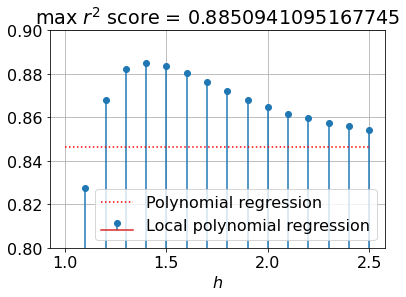

In [7]:
plt.figure()
plt.stem  (vH,         vScore,                   label='Local polynomial regression')
plt.plot  (vH[[0,-1]], [scoreLR, scoreLR], ':r', label='Polynomial regression')
plt.title (f'max $r^2$ score = {vScore.max()}')
plt.xlabel('$h$')
plt.ylim  ([0.8, 0.9])
plt.legend()
plt.grid  ()

### (Hard) exercise
* Use regularization to improve the R2 score.  
Hint: when using regularization you can consider a higher polynomial degree.

In [8]:
from sklearn.linear_model  import Lasso
from sklearn.preprocessing import StandardScaler

#-- Gaussian kernel:
def Kernel(vU):
    return np.exp(-vU**2 / (2 * h)**2)

#-- Estimate f(x_0):
def LocalPolynomialRegression2(vX0, mX, vY, h):
    
    #-- Compute u = H^-1||x_0 - x_i||
    vU = cdist(vX0[None,:], mX, metric='mahalanobis') #-- vU.shape = (1, N)
    vU = vU.squeeze()                                 #-- vU.shape = (N,)
    
    #-- Compute weightes aorund x_0:
    vW  = Kernel(vU / h)
    
    #-- Lasso (with pipeline):
    oLasso = Pipeline([
        ('Remove x0',     FunctionTransformer(lambda mX: mX - vX0)         ),
        ('Poly_Features', PolynomialFeatures (degree=3, include_bias=False)),
        ('z_score',       StandardScaler     ()                            ),
        ('Lasso',         Lasso              (alpha=0.002)                 ),
    ])
      
    #-- Fit & predict:
    oLasso.fit(mX, vY, **{'Lasso__sample_weight': vW})
    yHat = oLasso.predict(vX0[None,:])
    
    return yHat

#### Apply model:

In [9]:
N      = len(vY)
vHatY  = np.full(N, np.nan)
h      = 1.4

for ii in range(N):
    #-- Leave one out cross-validation:
    mXi       = np.delete(mX, ii, 0)
    vYi       = np.delete(vY, ii)
    vXi       = mX[ii,:]
    vHatY[ii] = LocalPolynomialRegression2(vXi, mXi, vYi, h)

score = r2_score(vY, vHatY)
score

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9034212076375745, tolerance: 0.040742600860543154
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09571727278693132, tolerance: 0.03758739864884024
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15662090684189067, tolerance: 0.04200297797039303
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08360610545278035, tolerance: 0.03215676710295595
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06361131363528827, tolerance: 0.03192373548786488
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3620557555319195, tolerance: 0.03434317531895168
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04783489010502251, tolerance: 0.03709022801970065
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11801725067362767, tolerance: 0.035286895621059466
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09422386535872818, tolerance: 0.035366784787532315
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2525774389393085, tolerance: 0.0368599229195445
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09291870977203942, tolerance: 0.03713462769960699
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18283912516299594, tolerance: 0.03877613825435906
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045929352205892116, tolerance: 0.03724512358940812
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34418183801289004, tolerance: 0.03836644464606596
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1106904551580854, tolerance: 0.04083886010373989
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8763738256797318, tolerance: 0.03942955478546473
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28543034670206424, tolerance: 0.04394507771412958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22084873817939155, tolerance: 0.04355717313297854
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08386063034812707, tolerance: 0.03381364396706877
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04825682171633616, tolerance: 0.036949655322777324
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30899338666883835, tolerance: 0.03488943988498197
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2124545019897397, tolerance: 0.044299437394227426
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8703565367105952, tolerance: 0.04631789290753493
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8048273074298997, tolerance: 0.03768711386675866
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1556284448531144, tolerance: 0.05402073951501771
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4740406225997447, tolerance: 0.041334912873518044
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21236886752142325, tolerance: 0.05530816702508467
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07183500584702074, tolerance: 0.03359439216968318
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4061074876240163, tolerance: 0.0364925032649907
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14895209818154598, tolerance: 0.03678471733239
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Ob

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16365296377255945, tolerance: 0.03583265997302152
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19774233121840012, tolerance: 0.03412603251918844
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18295481944581482, tolerance: 0.03405122677465953
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.110594081066967, tolerance: 0.04595514089880985
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4771197834054526, tolerance: 0.04637642391661704
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7403106921061777, tolerance: 0.04541639387646057
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: O

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8301894425605454, tolerance: 0.03903203668285214
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0371207614394748, tolerance: 0.037320009942096465
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7690305811467368, tolerance: 0.038685316180711374
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.355781096205284, tolerance: 0.03934526485567078
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5613305622686084, tolerance: 0.03956893720943691
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8806670588940477, tolerance: 0.04595708386694003
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: O

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.602016928873816, tolerance: 0.04261795730828683
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1278279448203676, tolerance: 0.04068288859838562
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8064475610350037, tolerance: 0.04319746430295513
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: O

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39028552583575404, tolerance: 0.037395174082688824
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5186736895433128, tolerance: 0.03925285569863122
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3713789948890494, tolerance: 0.03997805824242272
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11928029642756144, tolerance: 0.03742286141783683
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47599112907337826, tolerance: 0.038264783470658835
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38814378850904774, tolerance: 0.03545127104575578
  model = cd_fast.enet_coordinate_descent(
C:\Users\Or\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

0.8974849769655503